##### Author contributions
Please fill out for each of the following parts who contributed to what:
- Conceived ideas: 
- Performed math exercises: 
- Performed programming exercises:
- Contributed to the overall final assignment: 

Both of us (Nayeong and Annabelle) did all of the mentioned parts above (aside from the math part since we choose to use code instead).

# Recurrent neural networks


    Hand-in bug-free (try "Kernel" > "Restart & Run All") and including all (textual as well as figural) output via Brightspace before the deadline (see Brightspace).

Learning goals:
1. Get familiar with recurrent hidden units
1. Implement a simple RNN (Elman network) in PyTorch
1. Implement an LSTM-based neural network in PyTorch

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

### Exercise 1  (1 point)

Consider a recurrent neural network with one input unit $x$, one sigmoid recurrent hidden unit $h$, and one linear output unit $y$. The values of $x$ are given for 3 time points in `x_t`. As this is a very small RNN, $W^i$, $W^h$ and $W^o$ are given as the scalar values `w_i`, `w_h` and `w_o` respectively. The hidden unit has an added bias `h_bias`. The hidden unit state is initialized with `0.0`. The only 'value-manipulating' activation function in this network is the sigmoid activation $\sigma(\cdot)$ on the hidden unit. 

1. Write down the forward pass of this network for a specific time point $t$. 
1. What is the value of the hidden state $h$ after processing the last input `x_t[2]`? 
1. What is the output `y` of the network after processing the last input `x_t[2]`? 

\begin{eqnarray*}
h_t &=& \sigma(Ux(t)+Wh(t-1)+bias)\\ 
y_t &=& \sigma(Vh(t)+bias)\\
\end{eqnarray*}


For 1.2 and 1.3, you can either compute the solution by hand (show clearly how you arrived there, 3 decimal points) or write code to find the answer. 

In [92]:
# inputs over times 0, 1, 2:
x_t = [9.0, 4.0, -2.0]

# weights and bias terms: 
w_i = 0.5
w_h = -1.0
w_o = -0.7
h_bias = -1.0
y_bias = 0.0

### Solution 1

In [93]:
## LaTex or code here ##
def sigmoid(x):
    return 1/(1+np.exp(-x))

h_t = 0.0

for i in range(len(x_t)):
    h_t = sigmoid(w_i*x_t[i]+w_h*h_t)+h_bias
    y_t = sigmoid(w_o*h_t)+y_bias
    
print('The value of the hidden state is {}.'.format(h_t))
print("The output is {}.".format(y_t))

The value of the hidden state is -0.7072252802268861.
The output is 0.621297170441984.


### Code introduction

We will apply two recurrent neural networks to learn a dynamic variant of the *adding problem*. First, run the next cell and inspect the output. 

There is a stream of inputs to the network, two at each time step. The first input unit will receive a series of decimal numbers in the interval $[-1,1]$. The second input unit will receive the numbers $0$, $-1$, or $1$. The target is the sum of the preceding two decimal numbers that came together with the number $1$ (called the marker, `x` in the generated output), and it should be produced whenever a marker has been seen. In the beginning until two of these markers have been seen, the output will stay 0. 


Below you will find two functions: 
1. `create_addition_data`: Generates sequential training data sets `X` and `T` for the dynamic *adding problem*, returns numpy array.
1. `MyDataset`: a custom PyTorch dataset that makes sure dimensions are as PyTorch likes them, and can return individual samples the way PyTorch wants them.

Note, the data are represented in a dictionary called `data`. To access the training, validation, and testing data, you can call `data["train"]`, `data["valid]`, and `data["test"]` respectively.

In [94]:
def create_addition_data(n_samples=3000):
    # This is a dynamic variant of the adding problem. 
    
    # Random numbers in [-1.0,1.0]): 
    X1 = np.random.uniform(low=-1.0, high=1.0, size=(n_samples,) )   
    
    # Random markers [-1.0, 0.0, 1.0] (1.0 marks the numbers that should be added):
    X2 = np.random.choice([-1.0, 0.0, 1.0], size=(n_samples,), p=[0.25, 0.25, 0.5])
    
    # Combine
    X = np.vstack((X1, X2)).T.astype("float32")

    # Create targets
    T = np.zeros((n_samples, 1)).astype("float32")

    # Get indices of 1.0
    markers = np.nonzero(X2 == 1.0)[0]
    
    # Generate data
    mem = X1[markers[0]]
    for mi, marker in enumerate(markers[1:]):
        T[marker] = mem + X1[marker]
        mem = X1[marker]
                
    return X, T

In [95]:
# Long as the markers x are sparse
X, T = create_addition_data(n_samples=100)

# Print some data
print("Data for the adding problem (x marks 1.0):")
for t in range(X.shape[0]):
    print("Time: {:03d} \t x: ({:+.3f} , {}) \t t: {:+.3f} ".format(
        t, X[t,0], 'x' if X[t,1] == 1.0 else ' ', T[t,0]))

Data for the adding problem (x marks 1.0):
Time: 000 	 x: (-0.498 , x) 	 t: +0.000 
Time: 001 	 x: (-0.734 , x) 	 t: -1.231 
Time: 002 	 x: (-0.100 ,  ) 	 t: +0.000 
Time: 003 	 x: (+0.545 , x) 	 t: -0.189 
Time: 004 	 x: (-0.997 ,  ) 	 t: +0.000 
Time: 005 	 x: (+0.928 ,  ) 	 t: +0.000 
Time: 006 	 x: (-0.833 , x) 	 t: -0.288 
Time: 007 	 x: (+0.386 ,  ) 	 t: +0.000 
Time: 008 	 x: (+0.640 , x) 	 t: -0.193 
Time: 009 	 x: (-0.079 , x) 	 t: +0.560 
Time: 010 	 x: (+0.714 , x) 	 t: +0.634 
Time: 011 	 x: (-0.089 ,  ) 	 t: +0.000 
Time: 012 	 x: (-0.058 , x) 	 t: +0.655 
Time: 013 	 x: (+0.918 ,  ) 	 t: +0.000 
Time: 014 	 x: (+0.978 , x) 	 t: +0.920 
Time: 015 	 x: (-0.029 ,  ) 	 t: +0.000 
Time: 016 	 x: (+0.164 ,  ) 	 t: +0.000 
Time: 017 	 x: (+0.450 , x) 	 t: +1.429 
Time: 018 	 x: (-0.072 , x) 	 t: +0.379 
Time: 019 	 x: (+0.826 , x) 	 t: +0.754 
Time: 020 	 x: (+0.397 ,  ) 	 t: +0.000 
Time: 021 	 x: (-0.515 , x) 	 t: +0.310 
Time: 022 	 x: (-0.284 , x) 	 t: -0.799 
Time: 023 	 x:

In [96]:
# Make PyTorch dataset
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, X, T):
        self.X = torch.from_numpy(X).type(torch.FloatTensor) # [n_examples, n_samples, n_features]
        self.T = torch.from_numpy(T).type(torch.FloatTensor) # [n_examples, n_samples]
        
    def __getitem__(self, index):
        return self.X[index, :, :], self.T[index]
    
    def __len__(self):
        return self.X.size()[0]

In [97]:
n_examples = 9
n_samples = 3000
data = {}

# Define training data
X = np.zeros((n_examples, n_samples, 2))
T = np.zeros((n_examples, n_samples, 1))
for i_example in range(n_examples):
    X[i_example, :, :], T[i_example, :] = create_addition_data(n_samples)
data["train"] = torch.utils.data.DataLoader(MyDataset(X, T), batch_size=3)

# Define validation data
X = np.zeros((n_examples, n_samples, 2))
T = np.zeros((n_examples, n_samples, 1))
for i_example in range(n_examples):
    X[i_example, :, :], T[i_example, :] = create_addition_data(n_samples)
data["valid"] = torch.utils.data.DataLoader(MyDataset(X, T), batch_size=3)

# Define test data
X = np.zeros((n_examples, n_samples, 2))
T = np.zeros((n_examples, n_samples, 1))
for i_example in range(n_examples):
    X[i_example, :, :], T[i_example, :] = create_addition_data(n_samples)
data["test"] = torch.utils.data.DataLoader(MyDataset(X, T), batch_size=1)

### Exercise 2: training a network  (0.5 points)

We neede a function to train a `model`. This function `train_model(model, data, optimizer, criterion, n_epochs)` should do the following: 

1. Loop `n_epochs` times over the dataset, and loop over minibatches
1. Train the model on the training data and save the loss per epoch
1. Validate the model on the validation data and save the loss per epoch
1. The function should return the trained model and the losses

Note: this function is quite similar again as the function your wrote wor the MLP and CNN. The only difference is that we do not need to compute an accuracy, as we are performing regression here.

### Solution 2

In [98]:
def train_model(model, data, optimizer, criterion, n_epochs):
    train_data = data["train"]
    valid_data = data["valid"]
    train_loss = []
    valid_loss = []
    
    for epoch in range(n_epochs):
        #print(epoch)
        tem_val_loss = 0
        tem_train_loss = 0
        
        for i, d in enumerate(train_data):
            inputs, labels = d
            
            #Forward
            output = model(inputs)
            
            #Loss
            loss = criterion(output, labels)     
            
            #Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tem_train_loss += loss.item()
            
            #print("{}, {} loss: {}".format(epoch+1, i+1, tem_train_loss))
            train_loss.append(tem_train_loss)
            tem_train_loss = 0.0
            
            
        for i, d in enumerate(valid_data):
            inputs, labels = d

            #Forward
            output = model(inputs)
             
            #Loss
            validation_loss = criterion(output, labels)
            tem_val_loss += validation_loss.item()
            
            #print("{}, {} loss: {}".format(epoch+1, i+1, tem_val_loss))
            valid_loss.append(tem_val_loss)
            tem_val_loss = 0.0
    
    return model, train_loss, valid_loss

### Exercise 3: Testing a network  (1.5 points)

We neede a function to test a trained `model`. This function `test_model(model, data)` should do the following: 

1. Let `model` predict outputs on the testing data. For this, iterate through test data `data["test]` and pass each sample through `model`. 
1. Save the model output as well as the target output
1. The function should return the predicted and target outputs

### Solution 3

In [99]:
def test_model(model, data):
    test_data = data["test"]
    outputs = []
    targets = []
    for i, d in enumerate(test_data):
        x, target = d
        output = model(x)
        outputs.append(output)
        targets.append(target)
    return outputs, targets        

### Exercise 4: Simple RNN  (3 points)

We first implement a simple recurrent architecture (a simple [Elman network](http://mnemstudio.org/neural-networks-elman.htm)). 

1. First implement the linear layers `l1` and `l2`. They should lead from `n_input` input units over `n_hidden` hidden units to `n_out` output units.
1. Add a recurrent linear weight layer `hr`. These are weights that self-connect to the hidden units. The input will be the values of the `n_hidden` hidden units, and they should project back to the `n_hidden` hidden units. 
1. A forward pass will update the hidden state with the inputs and the recurrent layer weights, and produce the output from the hidden unit. Specifically you should do the following: 
    2. If we are at the first time point, the hidden state should be set to the input passed through `l1` and `tanh` activations.
    2. If the hidden state has information from previous time points: a) Pass the input through `l1`. b) Pass the hidden state through the recurrent weight layer `hr`. c) The sum of a) and b) should be passed through the `tanh` activation. d) The result should be the new hidden state (used for the next time point).
    2. Finally pass the hidden state through layer `l2`. This produces the output `y` for that time point.
1. The forward pass will receive data `x` with shape [batch_size, time_points, features]. So within the forward pass, you will have to loop over time points, performing the steps as descibed above. The output of the forward pass is then output `y` with shape [batch_size, time_points, 1].

Note: this exercise could also be done with nn.RNN(). However, we want you to understand what a RNN is doing, so we want you to use nn.Linear instead.

### Solution 4

In [100]:
class RNN(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_out):
        super(RNN, self).__init__()
        self.l1 = torch.nn.Linear(n_input, n_hidden)
        self.l2 = torch.nn.Linear(n_hidden, n_out)
        self.hr = torch.nn.Linear(n_hidden, n_hidden)
        
        self.tanh = nn.Tanh()
        self.use_gpu = True  
    
    def forward(self, x):
        #input consists of batch_size, time_points and features
        output = torch.zeros(x.shape[0], x.shape[1], 1)
        for i in range(x.shape[1]):
            if i == 0:
                hidden_state = self.l1(x[:,0,:])
                hidden_state = self.tanh(hidden_state)
            else:
                hidden_state = self.tanh(self.l1(x[:,i,:]) + self.hr(hidden_state))
            output[:,i,:] = self.l2(hidden_state)
            
        return output

### Exercise 5: Setup and run (1 point)

Try your simple `RNN` with the dynamic addition task. 

1. Define the model. `RNN` should have **2 hidden units**.
1. Define the loss as the Mean Squared Error loss, and use an Adam optimizer.
1. Train your model for several epochs on the data with `train_model`.
1. Plot the train and validation losses. 
1. Test the trained model with `test_model` 
1. Plot at least one target time series together with the predicted time series

Based on the losses and predictions, what would your conclusion be? Did the simple RNN learn the task? 

### Solution 5

In [104]:
rnn = RNN(2, 2, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn.parameters(), lr=0.01)

model, train_loss, val_loss = train_model(rnn, data, optimizer, criterion, 150)

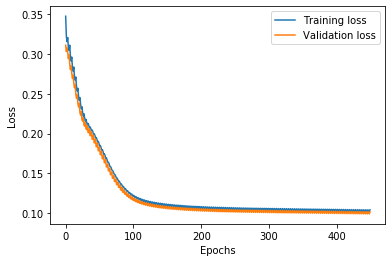

In [105]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["Training loss","Validation loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

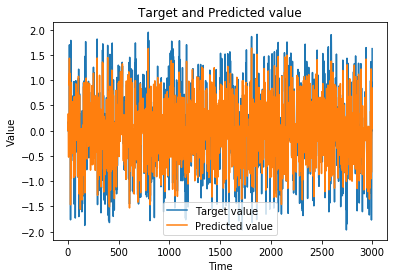

In [153]:
output, target = test_model(rnn, data) #length is 9, 1, 3000
out_list = []
tar_list = []

for i in range(len(output[0][0])):
    out_list.append(output[0][0][i])
    tar_list.append(target[0][0][i])

plt.plot(tar_list, label = "Target value")
plt.plot(out_list, label = "Predicted value")
plt.title('Target and Predicted value')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

### Exercise 6: LSTM RNN (2 points)

Long-Short Term Memory (LSTM) units have more [powerful functionality](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), such as selective forgetting, and they are able to keep track of long-term dependencies. This might be useful for the adding task. 

Implement the `LSTM` model:

1. `lstm` should be an `LSTM` layer leading from the `n_input` inputs to the `n_hidden` hidden units.
1. `fc` should be a fully-connected (linear) layer leading from the hidden units (output of `lstm`) to the `n_out` output units. 
1. The network does not make use of further activation functions. 

### Solution 6

In [142]:
class LSTM(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_out):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden)
        self.fc = torch.nn.Linear(n_hidden, n_out)
        
        self.use_gpu = True    
    
    def forward(self, x):
        output, states = self.lstm(x)
        output = self.fc(output)
        return output
    

### Exercise 7: Setup and run (1 point)

Try your `LSTM` model with the dynamic addition task. 

1. Define the model. `LSTM` should have **2 hidden units**.
1. Define the loss as the Mean Squared Error loss, and use an Adam optimizer.
1. Train your model for several epochs on the data with `train_model`.
1. Plot the train and validation losses. 
1. Test the trained model with `test_model` 
1. Plot at least one target time series together with the predicted time series

Did the LSTM network capture the task better? Did any of the two capture the task perfectly? Or are the two networks on par? 

### Solution 7

In [149]:
lstm = LSTM(2, 2, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)

model_lstm, train_loss_lstm, val_loss_lstm = train_model(lstm, data, optimizer, criterion, 150)

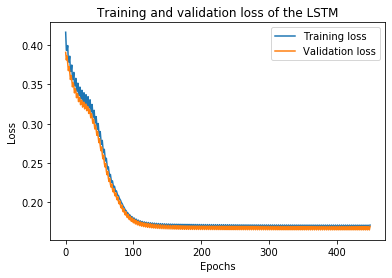

In [144]:
plt.plot(train_loss_lstm)
plt.plot(val_loss_lstm)
plt.title("Training and validation loss of the LSTM")
plt.legend(["Training loss","Validation loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

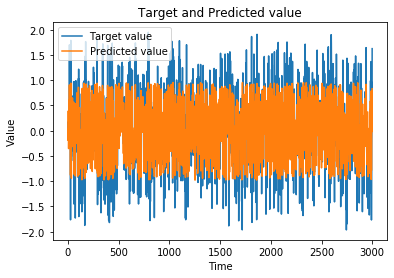

In [154]:
output_lstm, target_lstm = test_model(lstm, data) 

out_list_lstm = []
tar_list_lstm = []
for i in range(len(output_lstm[0][0])):
    out_list_lstm.append(output_lstm[0][0][i])
    tar_list_lstm.append(target_lstm[0][0][i])
    
plt.plot(tar_list_lstm, label = "Target value")
plt.plot(out_list_lstm, label = "Predicted value")
plt.title('Target and Predicted value')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

The LTSM network did not capture the task better. Neither of the networks captured the task perfectly, however the RNN was more accurate in both terms of losses and validity as well as it being visually more fitting. 
The LTSM network performed worse, it was however significantly faster.